# QAE Simulation

By: David Meshnick (dcm101)

Source: [Quantum autoencoders with enhanced data encoding](https://arxiv.org/abs/2010.06599)

------------

## 0. Imports

In [1]:
import warnings
import time
import itertools
import random
import numpy as np
from scipy.optimize import minimize, basinhopping
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh
import scipy.integrate
import qiskit
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import SPSA
from utils import Mag
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
%matplotlib inline
cmap = plt.get_cmap("plasma") #'viridis'

## 1. Quantum Circuit

First, we want to get the ground state as input into the quantum circuit, so we set up an exact diagonalization. 

Adapted from: [tenpy](https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html)

In [2]:
def ising_groundstate(L, J, gx, gz=0): # gx is transverse field, gz the longitudinal
    """
    For comparison: obtain ground state energy from exact diagonalization.
    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

Then, we declare the simulator.

In [3]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 6 # system size
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

Next, we define the QAE circuit.

In [4]:
def prepare_circuit(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[2:(L+2)]):
#     for i,t in enumerate(thetas[0:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    circ.barrier()
    for i,t in enumerate(thetas[(L+2):]):
#     for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
    circ.barrier()
#     circ.ry(thetas[2*L], 4)
#     circ.ry(thetas[2*L+1], 5)
    circ.ry(thetas[0], 4)
    circ.ry(thetas[1], 5)
    circ.barrier()
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    return circ

Enable the QAE to handle feature encodings, which allows for further optimization.

In [5]:
def feature_encoding(thetas, x):
    """
    thetas: parameters to be optimized 
    x: Ising model parameter (eg. field) 
    """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

Diagram of the QAE circuit.

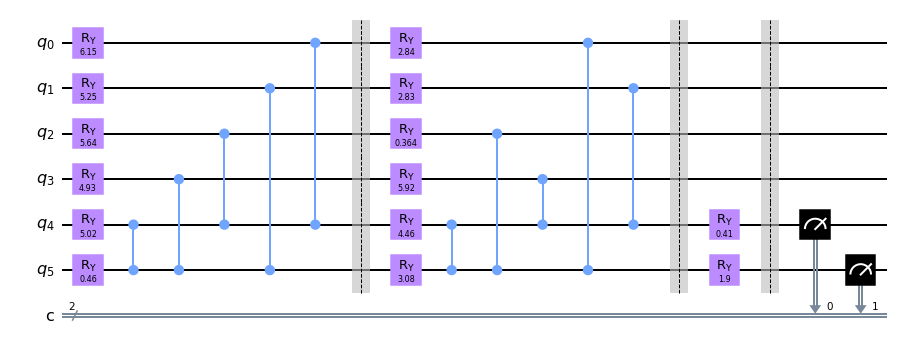

In [6]:
circ = prepare_circuit(thetas)
circ.draw('mpl') # trash qubits are at the bottom

## 2. Autoencoder Setup

Here, the circuit is executed on the Aer simulator and measurement outcomes on the trash qubits are stored. The random seed is also set.

In [7]:
np.random.seed(123)

In [8]:
def run_circuit(thetas, init_state, shots=100000):
    """ Execute the quantum circuit

    Parameters
    ----------
    thetas : _type_
        Parameters
    init_state : _type_
        Starting state of the quantum system
    shots : int, optional
        Number of steps, by default 100000

    Returns
    -------
    arraylike
        Counts of each state (11, 10, 00, 01)
    """
    circ = prepare_circuit(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
    return counts

init_state, E = ising_groundstate(6, 1., 1.6)
run_circuit(thetas, init_state)

{'11': 26823, '10': 16414, '00': 19568, '01': 37195}

Allow the quantum state to change over numerous steps.

In [1]:
def encoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """Apply the encoder to the state to iterate it

    Parameters
    ----------
    thetas : _type_
        Parameters
    J : _type_
        Interaction between two sites
    gx : _type_
        Transverse field
    gz : _type_
        Longitudinal field
    param_encoding : bool, optional
        Flag to enable feature encoding, by default False
    x : int, optional
        Ising model parameter (eg. field) , by default 0

    Returns
    -------
    _type_
        Evolved quantum state
    """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit(thetas, measurement=False)
    init_state, _ = ising_groundstate(L, J, g, gx)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,range(0,4))
    return traced_state

In [10]:
def encoder_decoder_evolv(thetas, J, gx, gz, param_encoding=False, x=0):
    """Apply the encoder and decoder to the state to iterate it

    Parameters
    ----------
    thetas : _type_
        Parameters
    J : _type_
        Interaction between two sites
    gx : _type_
        Transverse field
    gz : _type_
        Longitudinal field
    param_encoding : bool, optional
        Flag to enable feature encoding, by default False
    x : int, optional
        Ising model parameter (eg. field) , by default 0

    Returns
    -------
    _type_
        Evolved quantum state
    """
    if param_encoding: thetas = feature_encoding(thetas, x)
    circ = prepare_circuit(thetas, measurement=False)
    circ_dagger = circ.inverse()
    
    # encoder
    init_state, _ = ising_groundstate(L, J, gx, gz)
    state = Statevector(init_state)
    state = state.evolve(circ)
    traced_state = qiskit.quantum_info.partial_trace(state,[4,5])
    
    # decoder
    ancilla = np.zeros(4)
    ancilla[0] = 1
    ancilla = qiskit.quantum_info.DensityMatrix(ancilla)
    new_state = traced_state.expand(ancilla)
    final_state = new_state.evolve(circ_dagger)
    fid = qiskit.quantum_info.state_fidelity(Statevector(init_state), final_state)
    return final_state, init_state, fid

In [11]:
#reset random seed
np.random.seed(123)
random.seed(123)

Optimize the QAE with a cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [12]:
def cost_function_single(thetas, J, gx, gz, shots=1000, param_encoding=False, x=0):
    """Optimizes the circuit for a single element of parameters

    Parameters
    ----------
    thetas : _type_
        Parameters
    J : _type_
        Interaction between two sites
    gx : _type_
        Transverse field
    gz : _type_
        Longitudinal field
    shots : int, optional
        Number of steps, by default 1000
    param_encoding : bool, optional
        Flag to enable feature encoding, by default False
    x : int, optional
        Ising model parameter (eg. field) , by default 0

    Returns
    -------
    float
        Cost function of optimization
    """
    init_state, _ = ising_groundstate(L, J, gx, gz)
    if param_encoding: thetas = feature_encoding(thetas, x) 
    out = run_circuit(thetas, init_state, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots

In [13]:
def cost_function(thetas, ising_params, shots=1000, param_encoding=False, x=0):
    """Optimizes the circuit for a set of ising parameters

    Parameters
    ----------
    thetas : _type_
        Parameters
    ising_params : arraylike
        Set of ising parameters (J, gx, gz)
    shots : int, optional
        Number of steps, by default 1000
    param_encoding : bool, optional
        Flag to enable feature encoding, by default False
    x : int, optional
        Ising model parameter (eg. field) , by default 0

    Returns
    -------
    _type_
        Cost function of optimization
    """
    cost = 0.
    n_samples = len(ising_params)
    for i, p in enumerate(ising_params):
        J, gx, gz = p
        if param_encoding: 
            cost += cost_function_single(thetas, J, gx, gz, shots, param_encoding, x[i])
        else:
            cost += cost_function_single(thetas, J, gx, gz, shots, param_encoding)
    return cost/n_samples

In [14]:
def optimize(ising_params, thetas=None, shots=1000, max_iter=400, param_encoding=False, x=0):
    """Optimizes the circuit

    Parameters
    ----------
    ising_params : arraylike
        Set of ising parameters (J, gx, gz)
    thetas : _type_
        Parameters, by default None
    shots : int, optional
        Number of steps, by default 1000
    max_iter : int, optional
        Maximum iteration bound for SPSA optimizer, by default 400
    param_encoding : bool, optional
        Flag to enable feature encoding, by default False
    x : int, optional
        Ising model parameter (eg. field) , by default 0

    Returns
    -------
    arraylike
        Cost optimizations
    """
    np.random.seed(123)
    if thetas is None:
        n_params = (2*L+2)*2 if param_encoding else (2*L+2)
        thetas = np.random.uniform(0, 2*np.pi, n_params) # initial parameters without feature encoding
    
    # Print initial cost
    print("Initial cost: {:.3f}".format(cost_function(thetas, ising_params, shots, param_encoding, x)))
    print(thetas)
    
    # Save the immediate results
    counts, values, accepted = [], [], []
    def store_intermediate_result(eval_count, parameters, mean, std, ac):
        values.append(mean)
        accepted.append(ac)

    # Initialize optimizer
    optimizer = SPSA(maxiter=max_iter, callback=store_intermediate_result)

    # Optimize
    start_time = time.time()
    ret = optimizer.optimize(
                            num_vars=len(thetas),
                            objective_function=(lambda thetas: cost_function(thetas, ising_params, shots, param_encoding, x)),
                            initial_point=thetas
                            )
    print("Time: {:.5f} sec".format(time.time()-start_time))
    print(ret)
    return ret[0], values, accepted

Test the optimization

In [15]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params, max_iter=40)

Initial cost: 0.873
[4.37604495 1.79786647 1.42534972 3.46401286 4.52055686 2.65845629
 6.1623232  4.30291215 3.02178426 2.46374703 2.15625107 4.58075441
 2.75563068 0.37496728]
Time: 8.14003 sec
(array([4.71045237, 3.81425156, 1.46650164, 4.0340573 , 4.68711414,
       3.04508141, 6.29244276, 4.40296566, 2.384302  , 2.68090334,
       1.45443475, 4.64069492, 2.96518767, 0.68694141]), 0.43, 120)


In [16]:
params = [(-1.0, 0.1, 0.1)]
thetas, loss, accepted = optimize(params, max_iter=40)

Initial cost: 0.815
[4.37604495 1.79786647 1.42534972 3.46401286 4.52055686 2.65845629
 6.1623232  4.30291215 3.02178426 2.46374703 2.15625107 4.58075441
 2.75563068 0.37496728]
Time: 7.50324 sec
(array([3.1782428 , 3.1726245 , 3.08232353, 4.40465857, 6.31419656,
       2.10507063, 7.8146097 , 3.1454595 , 1.75243371, 2.01014854,
       3.37365891, 3.6655248 , 4.63748072, 1.41418643]), 0.532, 120)


Plot the test optimizations to ensure correctness. The left plot depicts the cost function diminishing over iterative steps, and the right plot depicts the fact that at each step, the results were accepted.

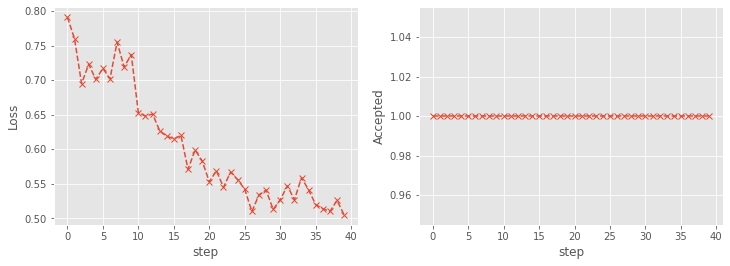

In [17]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.xlabel("step")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(accepted, "x--")
plt.xlabel("step")
plt.ylabel("Accepted")
plt.show()

## 3. Testing on Quantum Anomolies in Phase Diagrams

Let's test out the QAE on a quantum states from different simulated phases.

Source: [Variational Quantum Anomaly Detection: Unsupervised mapping of phase diagrams on a physical quantum computer](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043184)

First, we establish the initial states, and optimize the initial parameters.

In [18]:
Js = [-1]*2
gxs = [0.1,10]
gzs = [10,0.1]
params = list(zip(Js, gxs, gzs))
thetas, loss, accepted = optimize(params)
thetas_normal_phase = thetas

Initial cost: 0.957
[4.37604495 1.79786647 1.42534972 3.46401286 4.52055686 2.65845629
 6.1623232  4.30291215 3.02178426 2.46374703 2.15625107 4.58075441
 2.75563068 0.37496728]
Time: 106.80056 sec
(array([3.47748308, 2.80590424, 3.0642998 , 4.77231623, 2.99622191,
       1.50098951, 5.15202599, 2.71926812, 1.78171502, 1.90078967,
       1.86903401, 4.27282188, 2.79164496, 0.37672393]), 0.16649999999999998, 1200)


Here, we plot the cost function of this optimization.

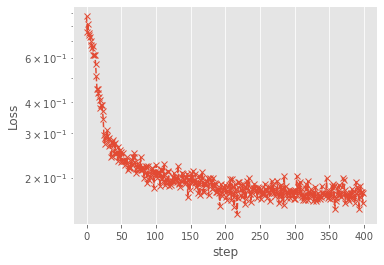

In [19]:
thetas = thetas_normal_phase

plt.style.use("ggplot")
fig = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(loss, "x--")
plt.yscale("log")
plt.xlabel("step")
plt.ylabel("Loss")
plt.show()

Now, let's run the states through the QAE.

In [20]:
points = 50
J = -1.0
gxs = np.logspace(-2, 2, points)
gzs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gxs,gzs)
cost = np.zeros((points,points))
Smags = np.zeros((points,points))
shots = 1000
for i,gx in enumerate(gxs):
    for j,gz in enumerate(gzs):
        cost[i,j] = cost_function_single(thetas, J, gx, gz, shots=shots)
        init_state, _ = ising_groundstate(5, J, gx, gz)
        Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state

/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/3837668684.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  Smags[i,j] = init_state.T.conj()@Mag(5,-1)@init_state


Then, let's plot the cost of the QAE trained on the phase state.

/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/3552365054.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/3552365054.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(im, ax=ax)
/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/3552365054.py:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/35

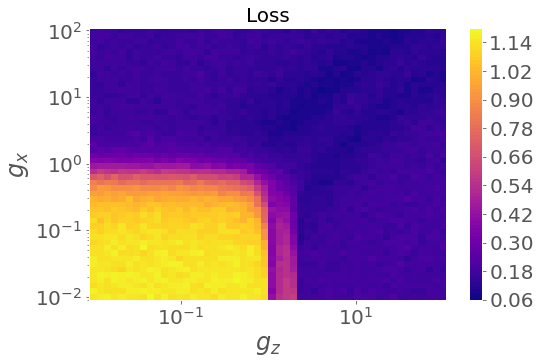

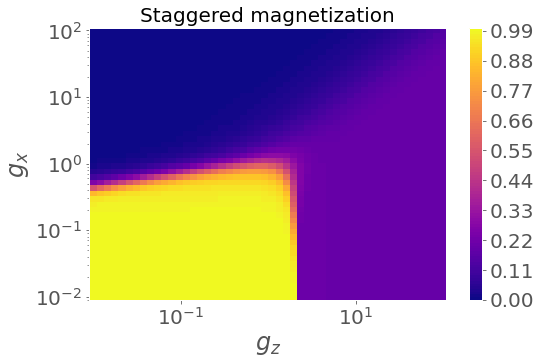

In [21]:
plt.style.use("ggplot")
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(cost.min(),cost.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, cost, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

plt.style.use("ggplot")
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
nbins=100
ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(Smags.min(),Smags.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, Smags, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Staggered magnetization",fontsize=20)
ax.set_xlabel(r"$g_z$",fontsize=24)
ax.set_ylabel(r"$g_x$",fontsize=24)
ax.tick_params(labelsize=20)

To finish off the simulation:

In [22]:
J = -1
gxs = np.logspace(-2, 2, 50)
gz = .01
cost1, Smags1, Smags12 = [], [], []
shots = 10000
Ll = 5
for gx in gxs:
    cost1.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags1.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags12.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))
    
gzs = np.logspace(-2, 2, 50)
gx = .01
cost2, Smags2, Smags22 = [], [], []
for gz in gzs:
    cost2.append(cost_function_single(thetas, J, gx, gz, shots=shots))
    init_state, _ = ising_groundstate(Ll, J, gx, gz)
    Smags2.append(np.real(init_state.T.conj()@Mag(Ll,-1)@init_state))
    init_state, _ = ising_groundstate(Ll+2, J, gx, gz)
    Smags22.append(np.real(init_state.T.conj()@Mag(Ll+2,-1)@init_state))

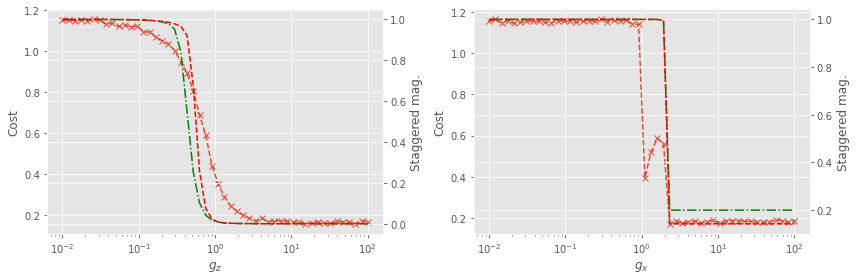

In [23]:
fig = plt.figure(figsize=(12,4))
ax1 = plt.subplot(121)
ax2 = ax1.twinx()
ax3 = plt.subplot(122)
ax4 = ax3.twinx()

ax1.set_xlabel(r"$g_z$")
ax1.set_ylabel("Cost")
ax1.plot(gzs, cost1, "x--")
ax2.plot(gzs, Smags1, "g-.")
ax2.plot(gzs, Smags12, "r--")
ax2.set_ylabel("Staggered mag.")
ax2.set_xscale("log")

ax3.set_xlabel(r"$g_x$")
ax3.set_ylabel("Cost")
ax3.plot(gzs, cost2, "x--")
ax4.plot(gzs, Smags2, "g-.")
ax4.plot(gzs, Smags22, "r--")
ax4.set_xscale("log")
ax4.set_ylabel("Staggered mag.")
fig.tight_layout()

/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/1744230630.py:8: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/1744230630.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/var/folders/35/1lj1czd51l35nx989blrnb5c0000gn/T/ipykernel_9193/1744230630.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


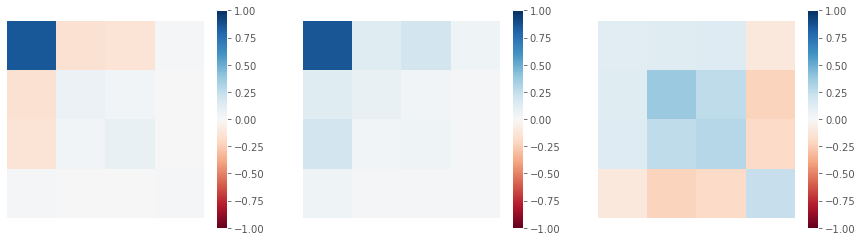

In [24]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(15,4))

plt.subplot(1, 3, 1)
J, g, gx = -1., .1, 10.
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
J, g, gx = -1., 10., .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 3)
J, g, gx = -1., .1, .1
traced_state = encoder_evolv(thetas, J, gx, gz)
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off')
# upper left corner corresponds to |00><00|, the first two images are the ones for which circuit was optimized
plt.show()